# Adversarial Attacks on Neural Networks

In this notebook, we will be discussing the concept of adversarial attacks on neural networks. We will be using the MNIST dataset for this purpose. We will be using the PyTorch library for building the neural network and the Foolbox library for generating adversarial attacks.

## Introduction
Adversarial attacks are a type of attack where the attacker tries to fool the neural network by adding some noise to the input image. The neural network will classify the image incorrectly after adding the noise. The noise added to the image is called adversarial noise. The adversarial noise is generated in such a way that it is not visible to the human eye but it is enough to fool the neural network. In this notebook, we will be white-box attacks where the attacker has access to the neural network architecture and the weights, with intention of reducing the accuracy of the neural network.

In [114]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical, plot_model
from keras.callbacks import TensorBoard
from sklearn.preprocessing import minmax_scale
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cleverhans
from datetime import datetime
from packaging import version
from keras_sequential_ascii import keras2ascii
import foolbox as fb

In [ ]:
%load_ext tensorboard

## Dataset

We will be using the MNIST dataset for this purpose. The MNIST dataset consists of 28x28 grayscale images of handwritten digits from 0 to 9. The dataset has 60,000 training images and 10,000 testing images. We will be using the testing images for generating adversarial attacks.

In [149]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

Now we show sample images from the MNIST dataset.

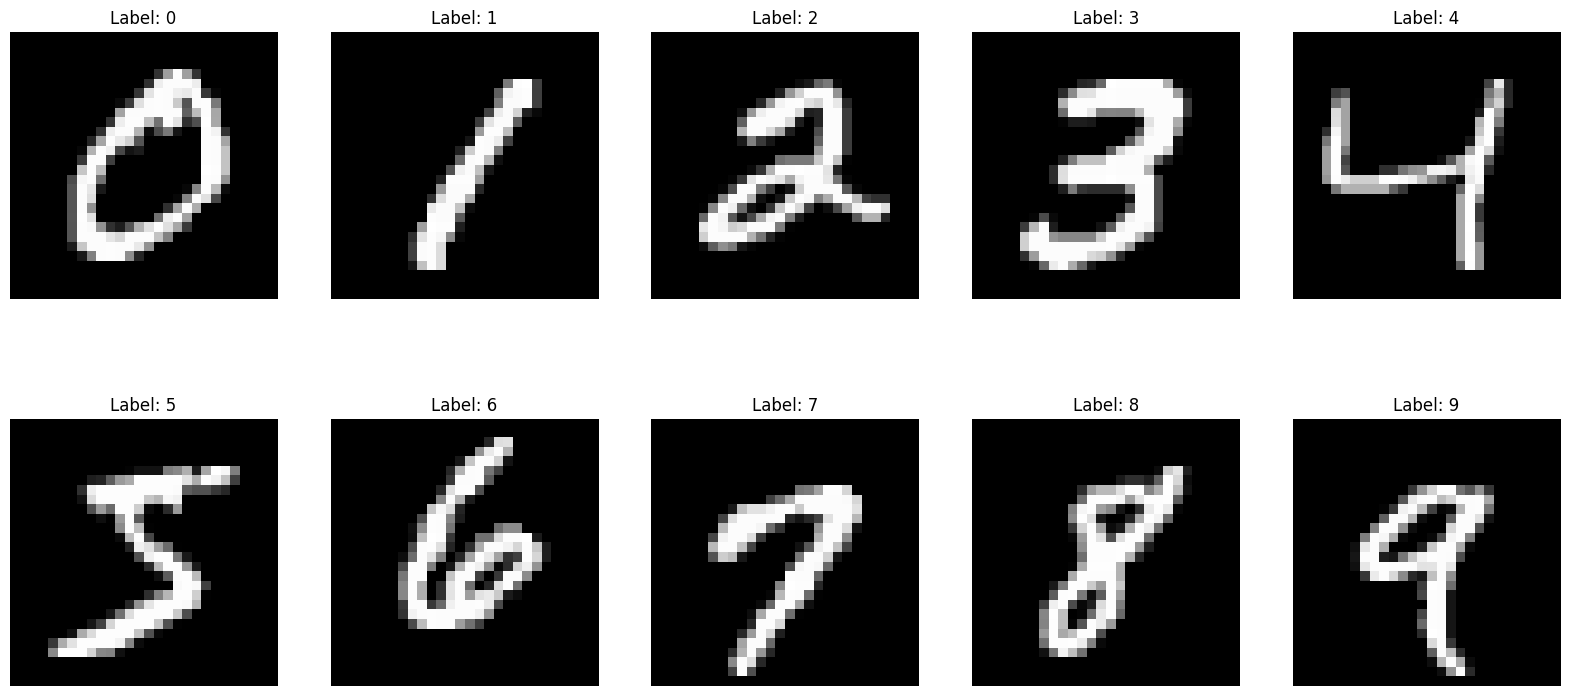

In [28]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.01)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[y_train == i][0], cmap="gray")
    plt.title(f"Label: {str(i)}")
    plt.axis("off")

Now we check the distribution of the classes in the dataset.

In [29]:
def plot_hist(hist, title, ax: plt.Axes):
    ax.hist(
        y_train,
        bins=range(11),
        alpha=0.7,
        label="Train",
        color="blue",
        edgecolor="black",
        align="left",
    )
    ax.set_title(f"Digit distribution in The {title} Set")
    ax.set_xlabel("Digit")
    ax.set_ylabel("Frequency")
    ax.legend()

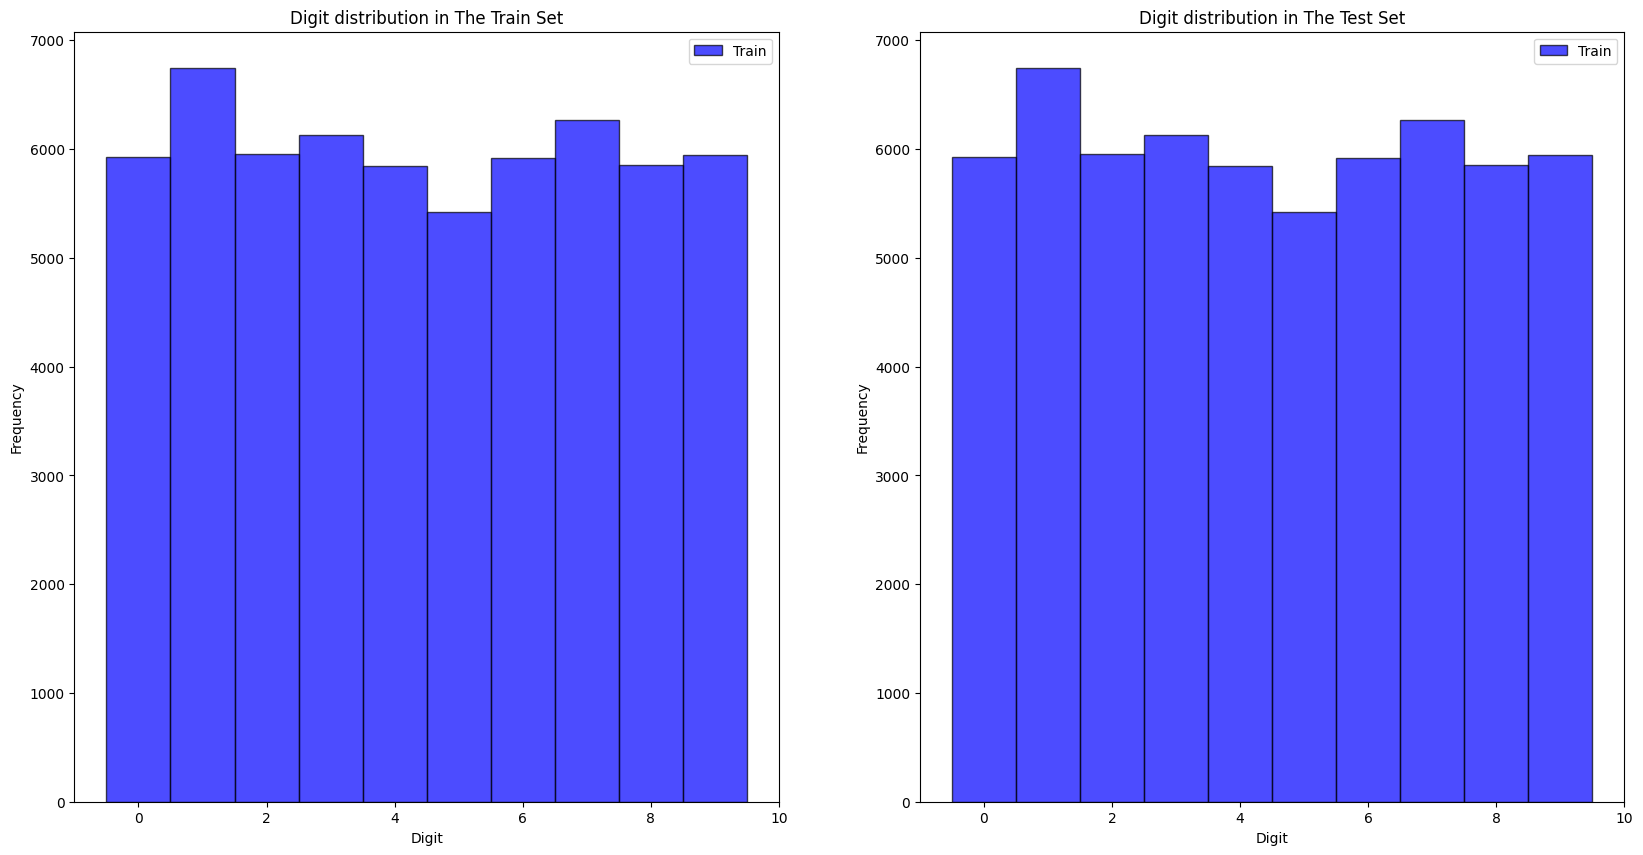

In [30]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))

plot_hist(y_train, "Train", ax[0])
plot_hist(y_test, "Test", ax[1])

As can be seen from the above plot, the dataset is somewhat balanced, so there is no need for us to balance the dataset.

Now by using min-max normalization, we normalize the pixel values of the images to the range [0, 1]. The reason for normalizing the pixel values is to make the training process faster and more stable. min-max normalization is done by subtracting the minimum pixel value and dividing by the maximum pixel value. More detailed reasons for normalization are as follows:

1. **Uniformity of scales**: Normalization ensures that all features contribute equally to the model's performance, regardless of their original scales. This is particularly important for algorithms that rely on distance metrics, such as k-nearest neighbors or support vector machines.

2. **Improved model performance**: Normalized data can enhance model performance and improve the accuracy of a model. It fosters stability in the optimization process, promoting faster convergence during gradient-based training.

3. **Prevention of numerical instability**: Normalization mitigates issues related to vanishing or exploding gradients, allowing models to reach optimal solutions more efficiently.

4. **Easier interpretation and visualization**: When all the features of a dataset are on the same scale, it becomes easier to identify and visualize the relationships between different features and make meaningful comparisons.


In [38]:
def print_sample_values(x):
    if len(x.shape) == 2:
        width, height = x.shape
        print("****" * width)
        for i in range(width):
            for j in range(height):
                print(f"{x[i, j]:3} ", end="") 
            print()
        print("****" * width)
    else:
        width, height = int(np.sqrt(x.shape[0])), int(np.sqrt(x.shape[0]))
        print("****" * width)
        for i in range(width):
            for j in range(height):
                print(f"{x[i * width + j]:3.2f} ", end="") if x[i * width + j] > 0 else print("    ", end="")
            print()
        print("****" * width)

In [32]:
sample_x = np.random.choice(x_train.shape[0])
print_sample_values(x_train[sample_x])

****************************************************************************************************************
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0  44 105 114 254 210  93   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0  22  60 148 229 253 253 253 253 248  99   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   8 188 253 253 254 253 253 253 249 149 112   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0  15 191 253 253 253 254 253 253 253 178   0   0   0   0   0 

In [150]:
# Reshape the images to 2D arrays
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

x_train_scaled = minmax_scale(x_train)
x_test_scaled = minmax_scale(x_test)

print("Scaled Train Images Shape:", x_train_scaled.shape)
print("Scaled Test Images Shape:", x_test_scaled.shape)

Scaled Train Images Shape: (60000, 784)
Scaled Test Images Shape: (10000, 784)


In [39]:
print_sample_values(x_train_scaled[sample_x])

****************************************************************************************************************
                                                                                                                
                                                                                                                
                                                                                                                
                                                                                                                
                                                        0.17 0.41 0.45 1.00 0.82 0.36                                 
                                            0.09 0.24 0.58 0.90 0.99 0.99 0.99 0.99 0.97 0.39                             
                                        0.03 0.74 0.99 0.99 1.00 0.99 0.99 0.99 0.98 0.58 0.44                             
                                    0.06 0.75 0.99 0.99 0.99 1.00 0.9

## Training the Neural Network

We will be using a simple neural network with two hidden layers for this purpose. 

### Architecture:

The neural network will have the following architecture:

1. Input layer: 784 neurons (28x28 pixels) to 512 neurons with ReLU activation function
2. Hidden layer 1: 512 neurons to 128 with ReLU activation function
3. Hidden layer 2: 128 neurons to 32 with ReLU activation function
4. Output layer: 32 neurons to 10 neurons (corresponding to the 10 classes) with softmax activation function


In the context of neural networks, the term "logit" often refers to the raw, unnormalized output of a neuron. These logits are typically passed through an activation function, such as the softmax function, to transform them into probabilities that sum to one.

The logit function itself is a crucial concept in statistics and machine learning, particularly within the field of logistic regression. It serves as a link function that maps probabilities ranging between 0 and 1 to real numbers on the entire number line, which can then be used to express linear relationships.

In a neural network, each neuron computes a weighted sum of its input, adds a bias, and then applies an activation function. The result of the weighted sum plus the bias is the logit. The activation function then transforms the logit into an output that depends on the task at hand. For example, in a binary classification problem, a sigmoid activation function might be used to squash the output between 0 and 1, interpreting it as a probability.

The last activation function in our neural network architecture is different because it serves a different purpose compared to the others. The activation functions in the hidden layers (ReLU) are used to introduce non-linearity into the network, allowing it to learn complex patterns.

On the other hand, the softmax activation function in the output layer is used to transform the raw, unbounded scores (logits) into a probability distribution over multiple classes. This is particularly useful for multi-class classification tasks, where an input needs to be assigned to one of several classes.

The softmax function takes a vector of real numbers as input and returns another vector of the same dimension, with values ranging between 0 and 1. Because these values add up to 1, they represent valid probabilities. The function assigns higher probabilities to classes with higher logits, which allows you to select the most likely class.

The mathematical formula for the softmax function:

$$
P(y = i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

where:
- $P(y = i)$ is the probability that the input belongs to class $i$.
- $z_i$ is the raw score or logit for class $i$.
- The denominator is the sum of exponentiated logits for all classes, ensuring the output is a valid probability distribution.


---

### Parameters:

- **Learning rate:** *6e-5*  
  this parameter is used for the rate at which the model learns, the higher the learning rate, the faster the model learns but it may not converge to the optimal solution. The lower the learning rate, the slower the model learns but it may converge to the optimal solution.
  
- **Epochs:** *25*  
  this parameter is used for the number of times the model will see the entire dataset. The higher the number of epochs, the more the model will learn but it may overfit the data. The lower the number of epochs, the less the model will learn but it may underfit the data. 

- **Optimizer:** *Adam*  
  this parameter is used for the optimization algorithm used to update the weights of the neural network. The Adam optimizer, short for Adaptive Moment Estimation, is an optimization algorithm used in deep learning. It was introduced by Diederik Kingma and Jimmy Ba in 2014. Adam optimizer combines the strengths of two other optimization algorithms: Momentum and Root Mean Square Propagation (RMSProp), It works as follows:

1. **Momentum**: This algorithm accelerates the gradient descent by considering the 'exponentially weighted average' of the gradients. Using averages makes the algorithm converge towards the minima at a faster pace.

2. **Root Mean Square Propagation (RMSProp)**: RMSProp is an adaptive learning algorithm that tries to improve AdaGrad. Instead of taking the cumulative sum of squared gradients like in AdaGrad, it takes the 'exponential moving average'. 
 
---

AdaGrad, short for Adaptive Gradient, is a stochastic optimization method that adapts the learning rate to the parameters. It performs smaller updates for parameters associated with frequently occurring features, and larger updates for parameters associated with infrequently occurring features.

In its update rule, AdaGrad modifies the general learning rate $η$ at each time step $t$ for every parameter $θ_{i}$ based on the past gradients for $θ_{i}$¹:

$$
θ_{t+1, i} = θ_{t, i} - \frac{η}{\sqrt{G_{t, ii} + ε}}g_{t, i}
$$

The benefit of AdaGrad is that it eliminates the need to manually tune the learning rate; most leave it at a default value of 0.01. Its main weakness is the accumulation of the squared gradients in the denominator. Since every added term is positive, the accumulated sum keeps growing during training, causing the learning rate to shrink and becoming infinitesimally small.

---


Adam maintains two estimates for each parameter of the model: a moving average of the gradient and a moving average of the squared gradient. It uses these estimates to adapt the learning rate for each weight of the neural network individually, which can lead to more efficient learning. The benefits of using Adam include its computational efficiency, little memory requirements, suitability for problems that are large in terms of data and/or parameters, and its effectiveness for non-stationary objectives.

Here's the mathematical aspect of the Adam Optimizer:

$$
\begin{aligned}
m_{t} &= \beta_{1} m_{t-1} + (1 - \beta_{1}) \left[\frac{\delta L}{\delta w_{t}}\right] \\
v_{t} &= \beta_{2} v_{t-1} + (1 - \beta_{2}) \left[\frac{\delta L}{\delta w_{t}}\right]^{2}
\end{aligned}
$$

where:
- $m_{t}$ is the aggregate of gradients at time $t$ (current).
- $m_{t-1}$ is the aggregate of gradients at time $t-1$ (previous).
- $w_{t}$ are the weights at time $t$.
- $w_{t+1}$ are the weights at time $t+1$.
- $\alpha_{t}$ is the learning rate at time $t$.
- $\delta L$ is the derivative of the Loss Function.
- $\delta w_{t}$ is the derivative of weights at time $t$.
- $v_{t}$ is the sum of square of past gradients.
- $\beta$ is the moving average parameter (const, 0.9).
- $\varepsilon$ is a small positive constant ($10^{-8}$).


  
            
The last parameter for our neural network is the loss function.

- **Loss function:** *Cross-entropy loss*
The cross-entropy loss function is used to measure the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0. The cross-entropy loss function is defined as:

$$ L(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} y_{i} \log(\hat{y}_{i}) + (1 - y_{i}) \log(1 - \hat{y}_{i}) $$

where:
- $y$ is the true label.
- $\hat{y}$ is the predicted label.
- $N$ is the number of samples.
- $i$ is the index of the sample.
- $\log$ is the natural logarithm.
- $y_{i}$ is the true value of the $i$-th sample.
- $\hat{y}_{i}$ is the predicted value of the $i$-th sample.
- $L(y, \hat{y})$ is the loss function.

In [11]:
model = Sequential(
    [
        Input(shape=(784,)),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(10, activation="softmax"),
    ]
)

EPOCHS = 25
optimizer = Adam(learning_rate=6e-5)
model.compile(optimizer=optimizer, loss=sparse_categorical_crossentropy, metrics=["accuracy"])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 472,042 (1.80 MB)

 Trainable params: 472,042 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
logdir="../logs/AdversarialAttack/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

history = model.fit(x_train_scaled, y_train, epochs=EPOCHS, validation_split=0.2, callbacks=[tensorboard_callback], batch_size=64)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9921 - loss: 0.0260 - val_accuracy: 0.9801 - val_loss: 0.0809
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9932 - loss: 0.0245 - val_accuracy: 0.9806 - val_loss: 0.0786
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9926 - loss: 0.0251 - val_accuracy: 0.9789 - val_loss: 0.0832
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9929 - loss: 0.0239 - val_accuracy: 0.9803 - val_loss: 0.0791
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9931 - loss: 0.0250 - val_accuracy: 0.9801 - val_loss: 0.0787
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9937 - loss: 0.0217 - val_accuracy: 0.9806 - val_loss: 0.0797
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9931 - loss: 0.0222 - val_accuracy: 0.9803 - val_loss: 0.0802
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9936 - loss: 0.0206 - val_accuracy: 0.

In [ ]:
%tensorboard --logdir ../logs/AdversarialAttack/fit

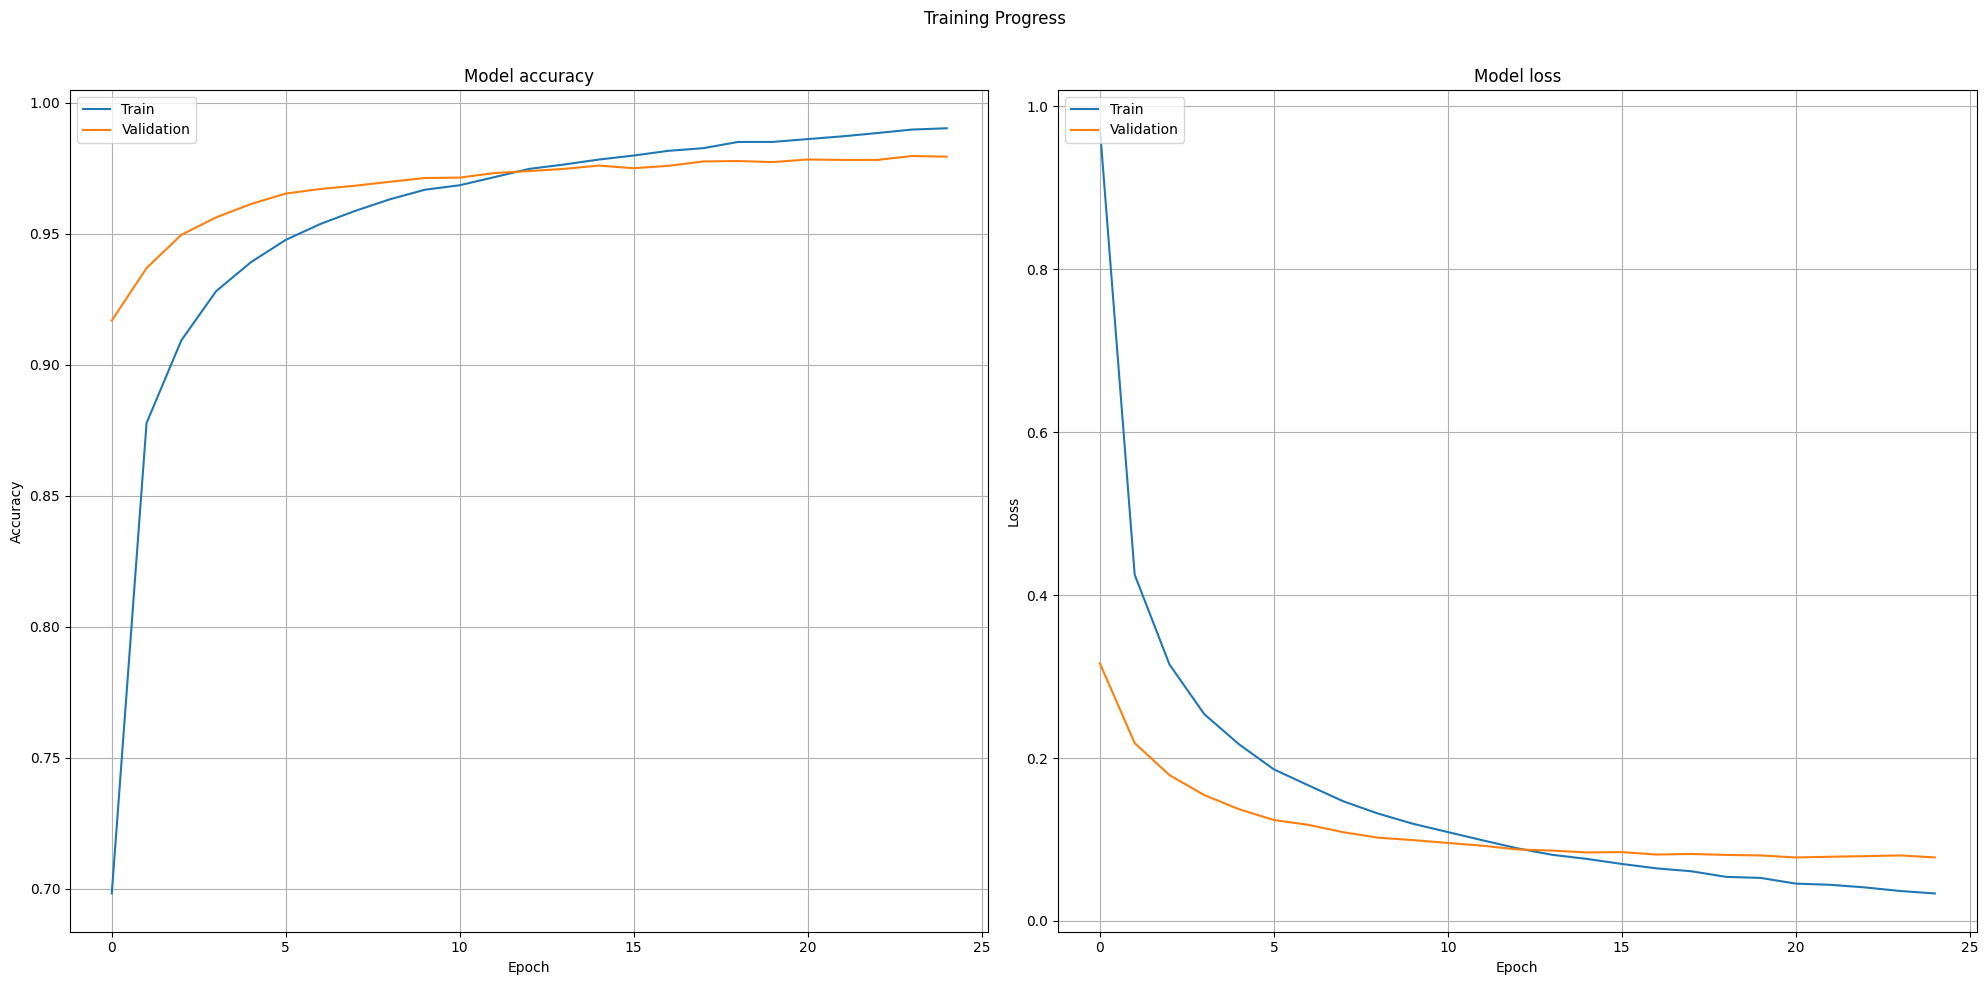

In [62]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)
plt.legend(["Train", "Validation"], loc="upper left")

plt.suptitle('Training Progress')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [78]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(y=history.history["accuracy"], mode='lines', name='Train Accuracy'), row=1, col=1)
fig.add_trace(go.Scatter(y=history.history["val_accuracy"], mode='lines', name='Validation Accuracy'), row=1, col=1)

fig.add_trace(go.Scatter(y=history.history["loss"], mode='lines', name='Train Loss'), row=1, col=2)
fig.add_trace(go.Scatter(y=history.history["val_loss"], mode='lines', name='Validation Loss'), row=1, col=2)

fig.update_xaxes(title_text="Epochs", row=1, col=1)
fig.update_xaxes(title_text="Epochs", row=1, col=2)

fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.update_layout(title_text="Model Accuracy and Loss", height=750, width=1550)

fig.show()

In [53]:
model.save("../data/AdversarialAttack/mnist_model.keras")

In [12]:
model.load_weights("../data/AdversarialAttack/mnist_model.keras")

c:\Users\attar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [13]:
test_loss, test_acc = model.evaluate(x_test_scaled, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.9785 - loss: 0.0809


In [79]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,416,128 (5.40 MB)

 Trainable params: 472,042 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 944,086 (3.60 MB)

## FGSM Attack

The Fast Gradient Sign Method (FGSM) is a simple yet effective method to generate adversarial examples. The FGSM attack works by using the gradients of the neural network to create an adversarial example. The steps involved in the FGSM attack are as follows:

1. Calculate the gradients of the loss with respect to the input image.
2. Take the sign of the gradients to create the perturbation.
3. Add the perturbation to the input image to create the adversarial example.
4. Clip the pixel values of the adversarial example to the range [0, 1].
5. The adversarial example is then fed to the neural network to get the output.

The FGSM attack is a white-box attack, which means that the attacker has access to the neural network architecture and the weights. The FGSM attack is a one-step attack, which means that it uses only one step to generate the adversarial example.

To implement the FGSM attack, we will be using the Foolbox library. Foolbox is a Python library that provides tools for creating adversarial examples and evaluating the robustness of neural networks. Foolbox supports various attacks, including the FGSM attack.

In [151]:
def create_adversarial_pattern(input_image, input_label, model):
    
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = sparse_categorical_crossentropy(input_label, prediction)
        
    gradient = tape.gradient(loss, input_image)
    
    return tf.sign(gradient)

In [152]:
def fgsm(input_image, input_label, model, epsilon=0.01):
    perturbation = create_adversarial_pattern(input_image, input_label, model)
    adversarial_image = input_image + epsilon * perturbation
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image

In [170]:
advesarial_test_images = fgsm(x_test_scaled, y_test, model, epsilon=0.05)

In [171]:
original_predictions = model.predict(x_test_scaled)
adversarial_predictions = model.predict(advesarial_test_images)

original_accuracy = np.mean(np.argmax(original_predictions, axis=1) == y_test)
adversarial_accuracy = np.mean(np.argmax(adversarial_predictions, axis=1) == y_test)

print(f"Original Accuracy: {original_accuracy}")
print(f"Adversarial Accuracy: {adversarial_accuracy}")

  1/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Original Accuracy: 0.9813
Adversarial Accuracy: 0.7038


In [172]:
attack_efficiency = original_accuracy - adversarial_accuracy
print(f"Attack Efficiency: {attack_efficiency}")

Attack Efficiency: 0.27749999999999997


The accuracy of the neural network has been calculated before and after the FGSM attack. The accuracy has dropped significantly after the FGSM attack, which shows that the neural network is vulnerable to adversarial attacks.

In [173]:
def calculate_attack_efficiency(label, original_predictions, adversarial_predictions):
    label_indices = np.where(y_test == label)
    
    original_accuracy = np.mean(np.argmax(original_predictions[label_indices], axis=1) == label)
    adversarial_accuracy = np.mean(np.argmax(adversarial_predictions[label_indices], axis=1) == label)
    
    attack_efficiency = original_accuracy - adversarial_accuracy
    return attack_efficiency

In [174]:
def calculate_attack_efficiency_for_all_labels(original_predictions, adversarial_predictions):
    attack_efficiencies = []
    for label in range(10):
        attack_efficiency = calculate_attack_efficiency(label, original_predictions, adversarial_predictions)
        attack_efficiencies.append(attack_efficiency)
    
    for label, attack_efficiency in enumerate(attack_efficiencies):
        print(f"Attack Efficiency for Label {label}: {attack_efficiency}")

In [175]:
calculate_attack_efficiency_for_all_labels(original_predictions, adversarial_predictions)

Attack Efficiency for Label 0: 0.10918367346938773
Attack Efficiency for Label 1: 0.4
Attack Efficiency for Label 2: 0.21317829457364335
Attack Efficiency for Label 3: 0.2504950495049505
Attack Efficiency for Label 4: 0.40631364562118133
Attack Efficiency for Label 5: 0.25
Attack Efficiency for Label 6: 0.13883089770354906
Attack Efficiency for Label 7: 0.28696498054474706
Attack Efficiency for Label 8: 0.29055441478439425
Attack Efficiency for Label 9: 0.40436075322101084


In [176]:
def plot_samples(adversarial, original, num_samples=20):
    num_rows = num_samples // 2 

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5)) 

    for i in range(num_rows):
        for j in range(2):
            sample_index = np.random.choice(original.shape[0])
       
            title_color = "green" if np.argmax(original_predictions[sample_index]) == y_test[sample_index] else "red"
            axes[i, j*2].imshow(original[sample_index].reshape(28, 28), cmap="gray")
            axes[i, j*2].set_title(f"Original Prediction: {np.argmax(original_predictions[sample_index])}", color=title_color)
            axes[i, j*2].axis("off")

            title_color = "green" if np.argmax(adversarial_predictions[sample_index]) == y_test[sample_index] else "red"
            axes[i, j*2+1].imshow(adversarial[sample_index].numpy().reshape(28, 28), cmap="gray")
            axes[i, j*2+1].set_title(f"Adversarial Prediction: {np.argmax(adversarial_predictions[sample_index])}", color=title_color)
            axes[i, j*2+1].axis("off")

    plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.8, wspace=0.2)
    plt.tight_layout()
    plt.show()

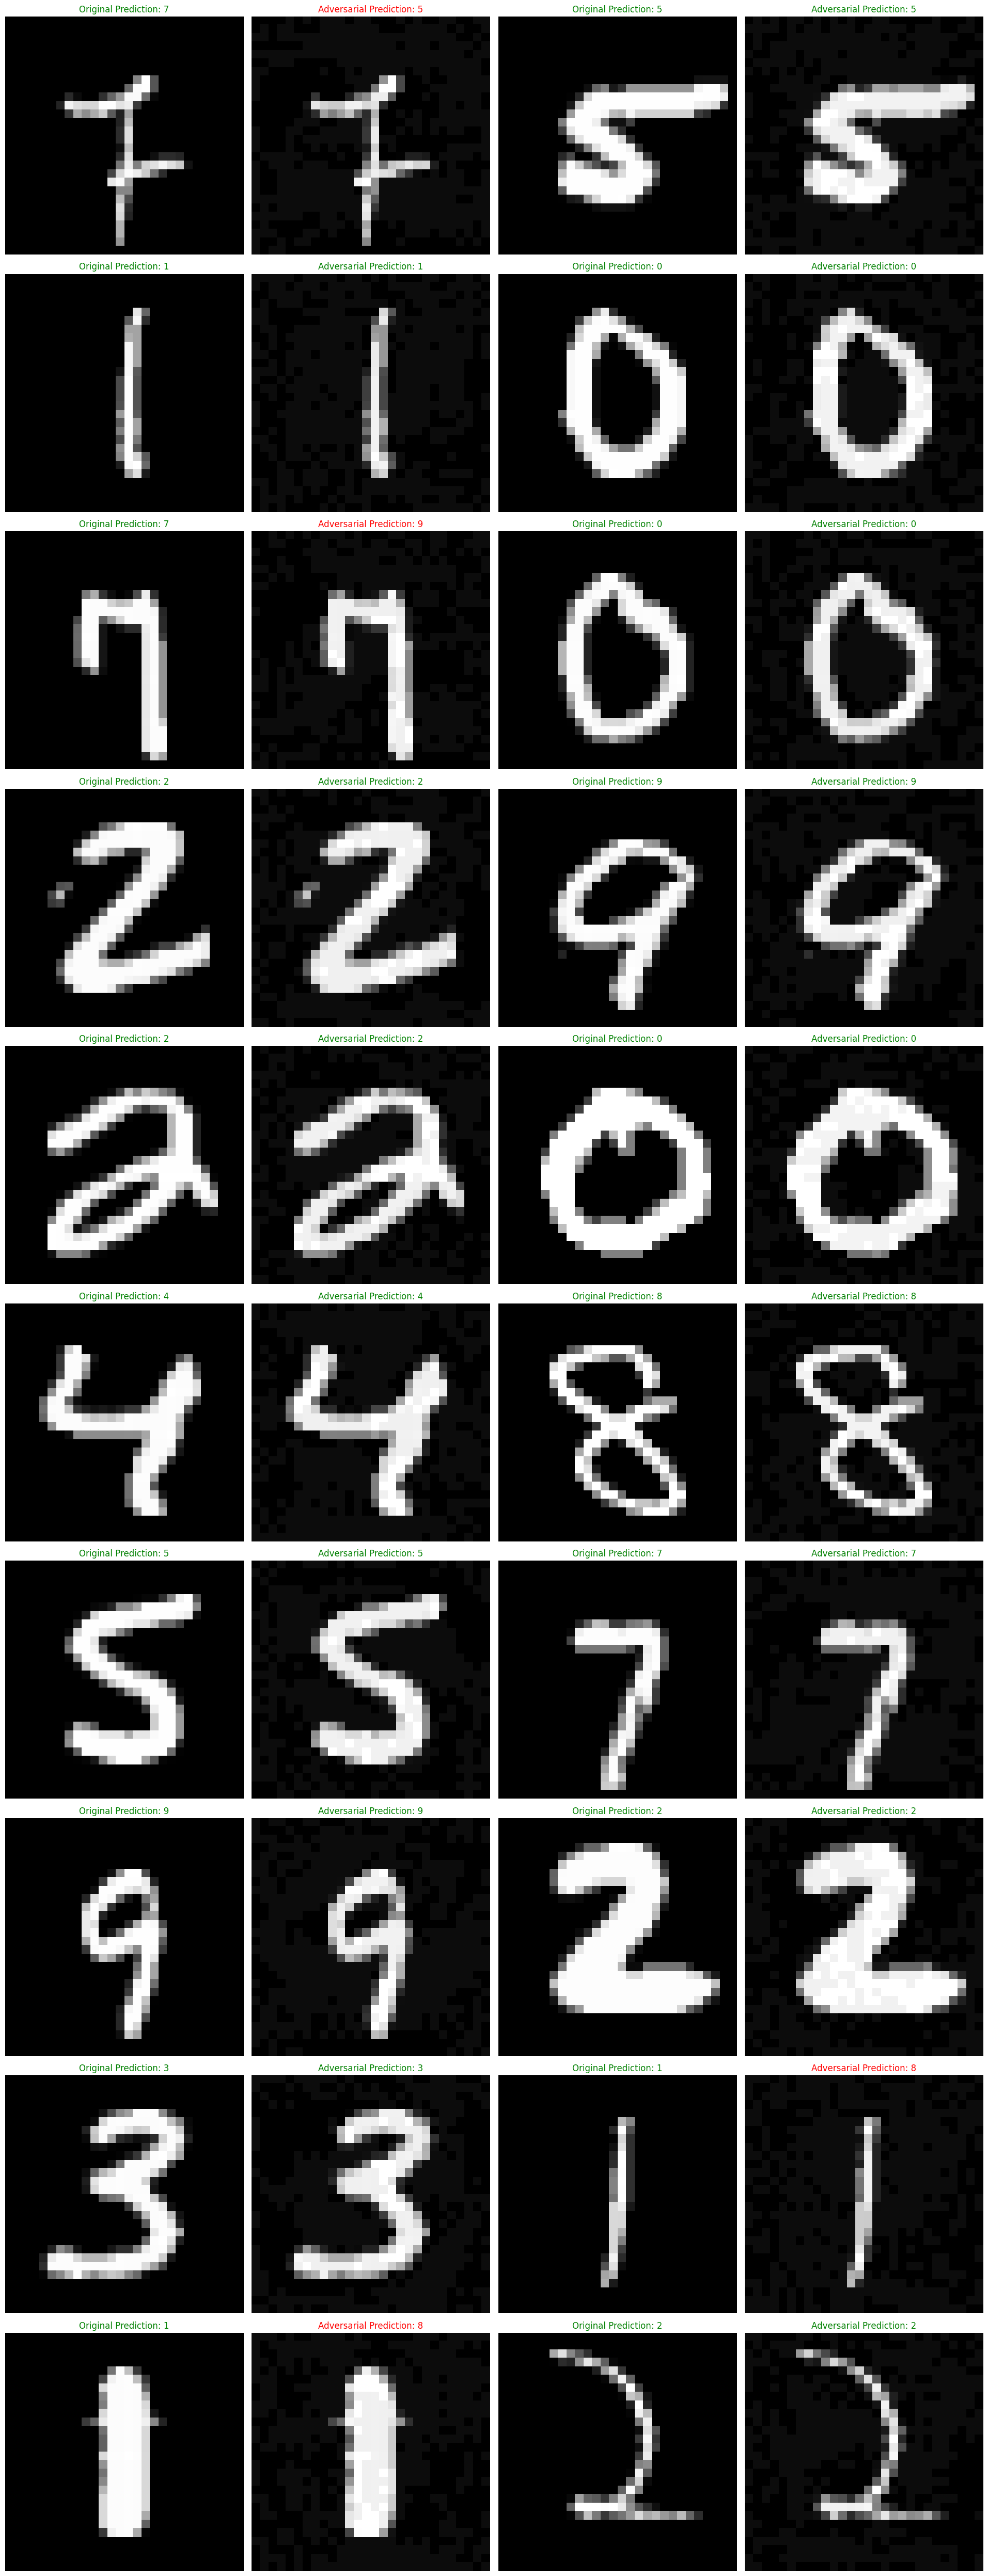

In [177]:
plot_samples(advesarial_test_images, x_test_scaled)

Now we repeat it with more epsilon values to see how the accuracy changes with different epsilon values.

In [178]:
advesarial_test_images = fgsm(x_test_scaled, y_test, model, epsilon=0.1)

In [179]:
original_predictions = model.predict(x_test_scaled)
adversarial_predictions = model.predict(advesarial_test_images)

original_accuracy = np.mean(np.argmax(original_predictions, axis=1) == y_test)
adversarial_accuracy = np.mean(np.argmax(adversarial_predictions, axis=1) == y_test)

print(f"Original Accuracy: {original_accuracy}")
print(f"Adversarial Accuracy: {adversarial_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Original Accuracy: 0.9813
Adversarial Accuracy: 0.2102


In [180]:
attack_efficiency = original_accuracy - adversarial_accuracy
print(f"Attack Efficiency: {attack_efficiency}")

Attack Efficiency: 0.7710999999999999


In [181]:
calculate_attack_efficiency_for_all_labels(original_predictions, adversarial_predictions)

Attack Efficiency for Label 0: 0.513265306122449
Attack Efficiency for Label 1: 0.9903083700440529
Attack Efficiency for Label 2: 0.6550387596899225
Attack Efficiency for Label 3: 0.7455445544554455
Attack Efficiency for Label 4: 0.9419551934826884
Attack Efficiency for Label 5: 0.7387892376681615
Attack Efficiency for Label 6: 0.5104384133611691
Attack Efficiency for Label 7: 0.9036964980544746
Attack Efficiency for Label 8: 0.7351129363449692
Attack Efficiency for Label 9: 0.9286422200198216


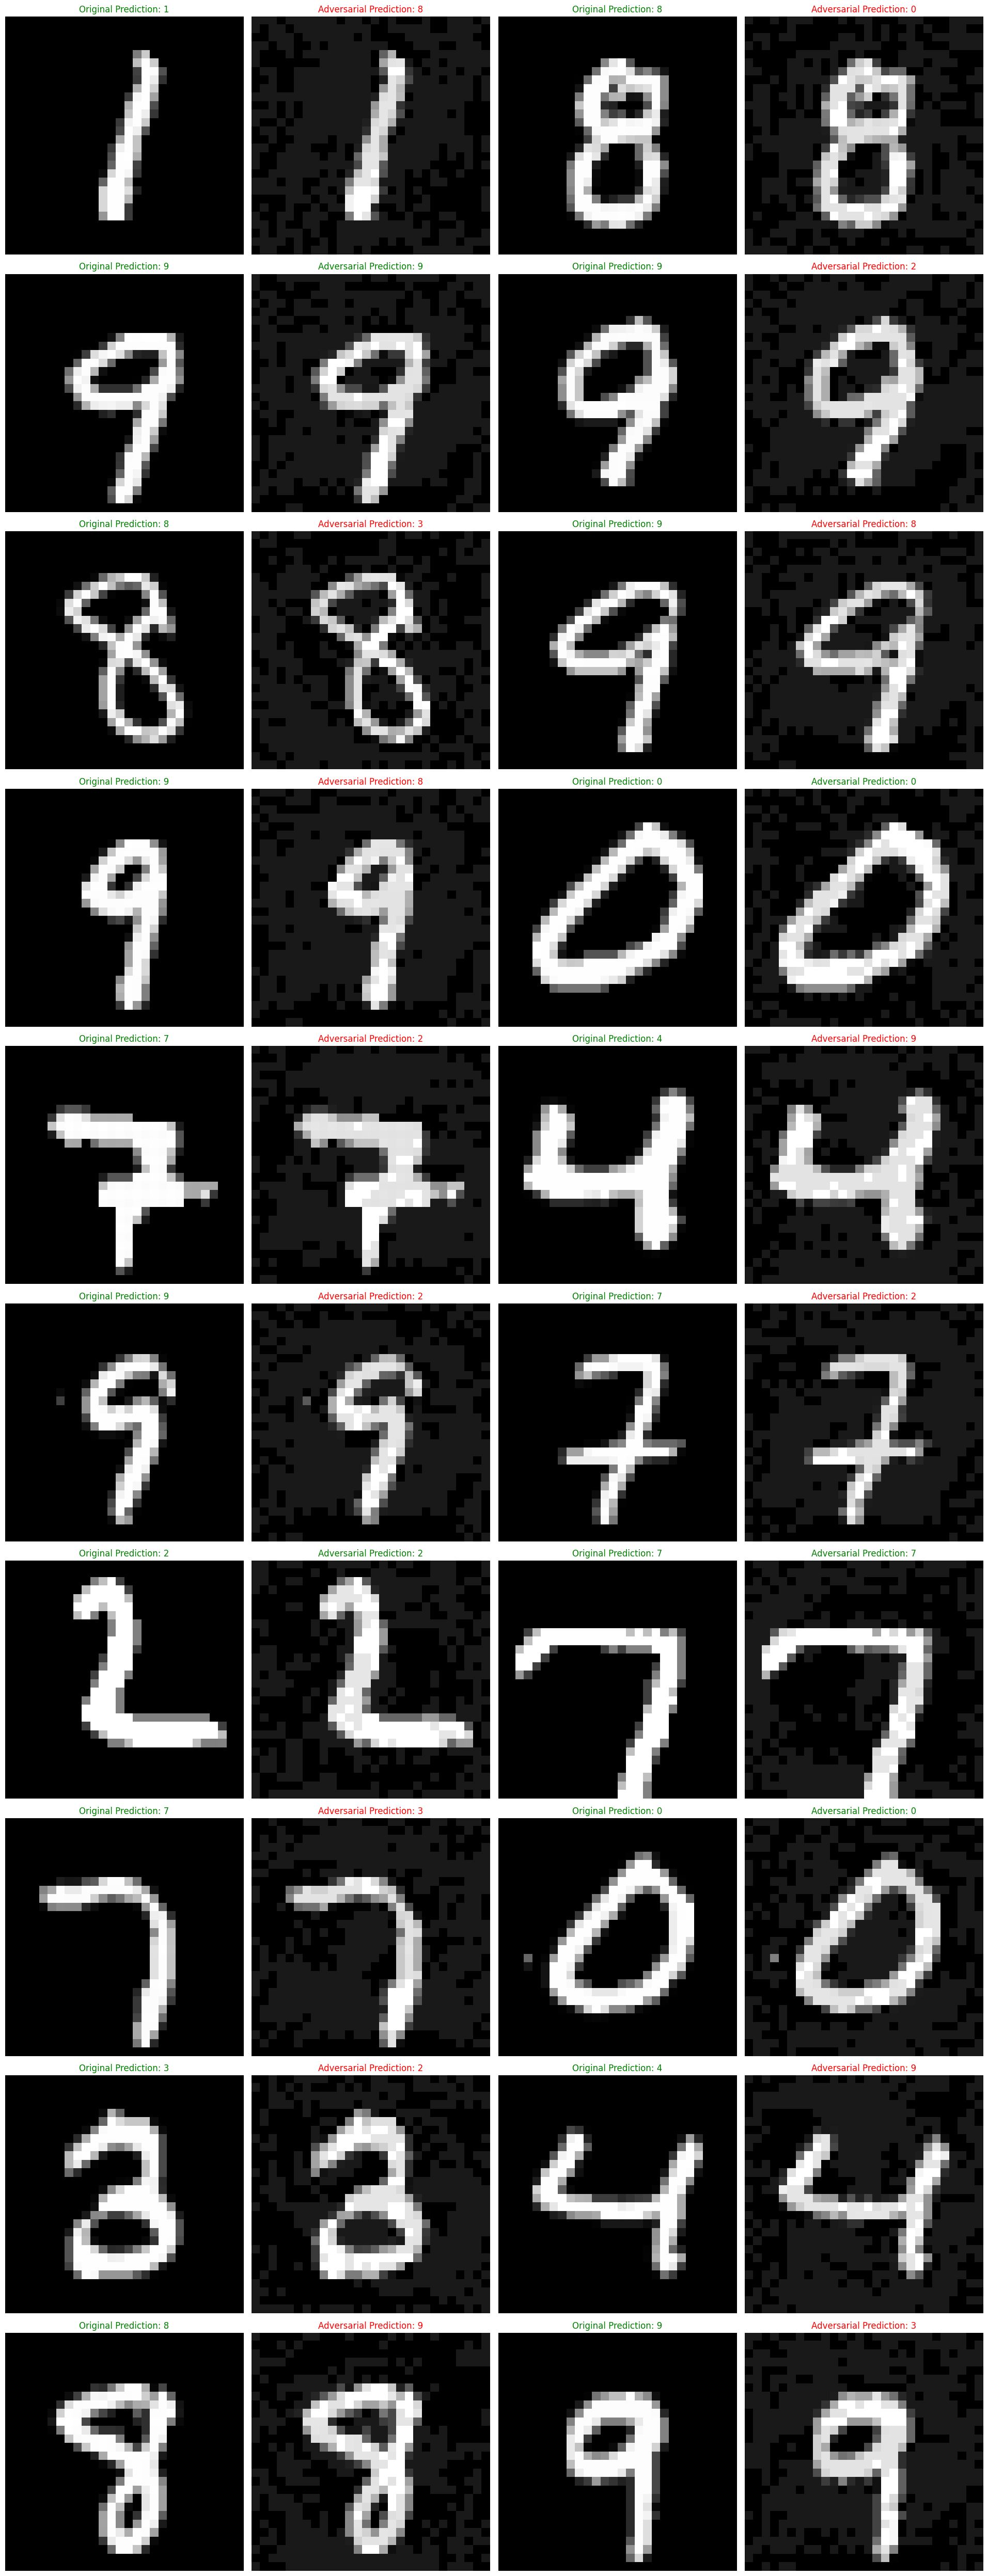

In [182]:
plot_samples(advesarial_test_images, x_test_scaled)

Now we will be implementing the FGSM attack on the neural network using the Foolbox library.

In [183]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0, 1))

attack = fb.attacks.LinfFastGradientAttack()

x_test_scaled_tensor = tf.convert_to_tensor(x_test_scaled, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [187]:
adversarial_test_images, perturbations, success = attack(fmodel, x_test_scaled_tensor, y_test_tensor, epsilons=0.2)

print(f"Attack Success Rate: {np.mean(success)}")

Attack Success Rate: 0.9748


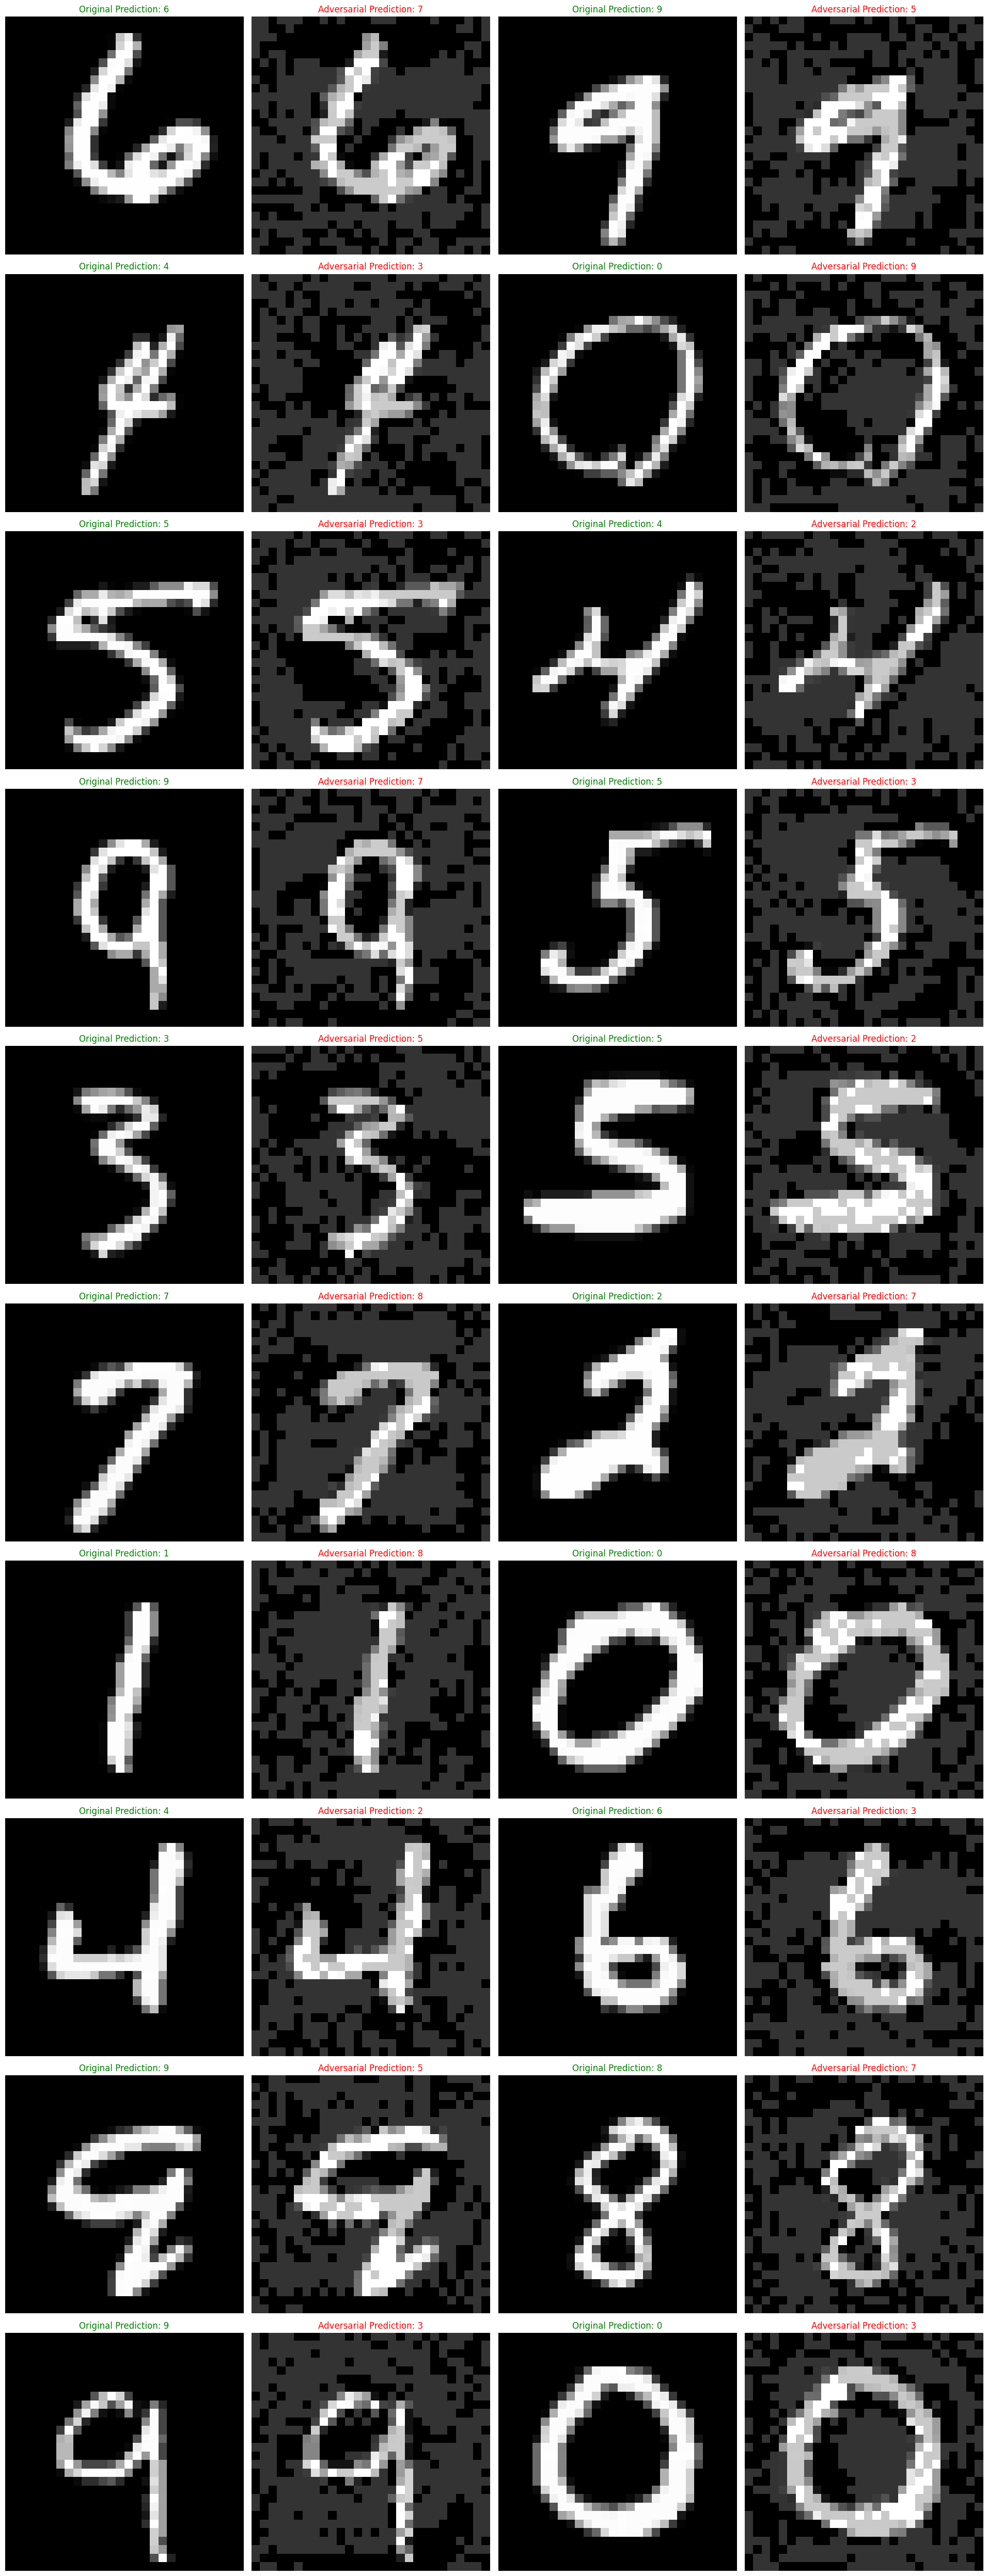

In [188]:
plot_samples(adversarial_test_images, x_test_scaled)